In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from scipy.interpolate import UnivariateSpline

# Prepare macroeconomic data

In [2]:
factors = pd.ExcelFile('factors_data.xlsx')
eur_df = factors.parse('EUR')

In [3]:
eur_data = pd.DataFrame({
    'Date_inflation_swap': pd.to_datetime(eur_df['Date_inflation_swap'], errors='coerce'),
    '5y5y_inflation_swap': pd.to_numeric(eur_df['5y5y inflation swap'], errors='coerce'),
    'Date_balance_sheet': pd.to_datetime(eur_df['Date_balance_sheet'], errors='coerce'),
    'balance_sheet': pd.to_numeric(eur_df['Balance sheet'], errors='coerce'),
    'Date_swap_spread': pd.to_datetime(eur_df['Date_swap_spread'], errors='coerce'),
    '10y_swap_spread': pd.to_numeric(eur_df['10y Swap Spread'], errors='coerce'),
    'Date_3m3m_1y3m': pd.to_datetime(eur_df['Date_3m3m_1y3m'], errors='coerce'),
    '3m3m_1y3m_curve_slope': pd.to_numeric(eur_df['3m3m-1y3m'], errors='coerce')
})
eur_data.head(15)

,Date_inflation_swap,5y5y_inflation_swap,Date_balance_sheet,balance_sheet,Date_swap_spread,10y_swap_spread,Date_3m3m_1y3m,3m3m_1y3m_curve_slope
0,2004-04-27,2.41,2000-01-07,791.851,2000-06-22,-63.718,2000-06-22,0.065
1,2004-04-29,2.43,2000-01-14,736.485,2000-06-23,-64.336,2000-06-23,0.078
2,2004-04-30,2.43,2000-01-21,745.291,2000-06-26,-65.292,2000-06-26,0.076
3,2004-05-04,2.43,2000-01-28,772.749,2000-06-27,-65.125,2000-06-27,0.076
4,2004-05-05,2.44,2000-02-04,762.476,2000-06-28,-65.210,2000-06-28,0.076
5,2004-05-06,2.46,2000-02-11,759.425,2000-06-29,-63.200,2000-06-29,0.049
6,2004-05-07,2.48,2000-02-18,755.854,2000-06-30,-61.904,2000-06-30,0.040
7,2004-05-10,2.45,2000-02-25,752.207,2000-07-03,-61.236,2000-07-03,0.037
8,2004-05-11,2.48,2000-03-03,777.649,2000-07-04,-61.586,2000-07-04,NaN
9,2004-05-12,2.53,2000-03-10,759.989,2000-07-05,-59.576,2000-07-05,0.036


In [4]:
# Define the daily date range
start_date = pd.to_datetime('2004-07-21')
end_date = pd.to_datetime(eur_df[['Date_inflation_swap', 'Date_balance_sheet', 'Date_swap_spread', 'Date_3m3m_1y3m']].max().max())
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

def spline_interpolate(dates, values, full_range):
    mask = (~pd.isna(dates)) & (~pd.isna(values))
    dates = pd.to_datetime(dates[mask])
    values = values[mask]
    if len(dates) < 4:
        return pd.Series(np.interp(full_range.astype(np.int64), dates.astype(np.int64), values), index=full_range)
    x = (dates - dates.min()).dt.days.values
    y = values.values
    spline = UnivariateSpline(x, y, s=0)
    x_full = (full_range - dates.min()).days
    return pd.Series(spline(x_full), index=full_range)
# Interpolate each macro variable
inflation_interp = spline_interpolate(
    eur_df['Date_inflation_swap'], eur_df['5y5y inflation swap'], date_range
)
balance_interp = spline_interpolate(
    eur_df['Date_balance_sheet'], eur_df['Balance sheet'], date_range
)
swap_spread_interp = spline_interpolate(
    eur_df['Date_swap_spread'], eur_df['10y Swap Spread'], date_range
)
curve_slope_interp = spline_interpolate(
    eur_df['Date_3m3m_1y3m'], eur_df['3m3m-1y3m'], date_range
)

# Build the interpolated macro DataFrame
macro_interp_df = pd.DataFrame({
    'date': date_range,
    '5y5y_inflation_swap': inflation_interp.values,
    'balance_sheet': balance_interp.values,
    '10y_swap_spread': swap_spread_interp.values,
    '3m3m_1y3m_curve_slope': curve_slope_interp.values
})
# Round balance sheet to five decimal places
macro_interp_df['balance_sheet'] = macro_interp_df['balance_sheet'].round(5)
pd.set_option('display.float_format', '{:.5f}'.format)

macro_interp_df.head(50)


,date,5y5y_inflation_swap,balance_sheet,10y_swap_spread,3m3m_1y3m_curve_slope
0,2004-07-21,2.56000,882.39701,-11.28700,0.73100
1,2004-07-22,2.50000,885.40473,-11.22900,0.72700
2,2004-07-23,2.51000,887.63100,-10.84100,0.72700
3,2004-07-24,2.52367,888.79801,-10.64800,0.73658
4,2004-07-25,2.52278,889.02564,-10.73337,0.74970
5,2004-07-26,2.52000,888.53321,-11.00300,0.77200
6,2004-07-27,2.52000,887.54002,-11.22100,0.79700
7,2004-07-28,2.51000,886.26538,-10.99900,0.79600
8,2004-07-29,2.51000,884.92860,-11.03100,0.79200
9,2004-07-30,2.50000,883.74900,-10.94200,0.72800


In [5]:
macro_interp_df = macro_interp_df[:-10]
macro_interp_df.tail(30)

,date,5y5y_inflation_swap,balance_sheet,10y_swap_spread,3m3m_1y3m_curve_slope
7600,2025-05-12,2.09500,6296.05585,8.02000,-0.08900
7601,2025-05-13,2.10830,6294.51304,7.19500,-0.09000
7602,2025-05-14,2.12460,6293.20991,7.40400,-0.10700
7603,2025-05-15,2.10500,6292.23429,7.54600,-0.11800
7604,2025-05-16,2.09500,6291.67400,6.49500,-0.13500
7605,2025-05-17,2.09252,6291.57967,6.00986,-0.13989
7606,2025-05-18,2.09226,6291.85312,6.03208,-0.13500
7607,2025-05-19,2.09330,6292.35894,5.82700,-0.13100
7608,2025-05-20,2.09880,6292.96173,5.38600,-0.12900
7609,2025-05-21,2.11550,6293.52611,6.06300,-0.11600


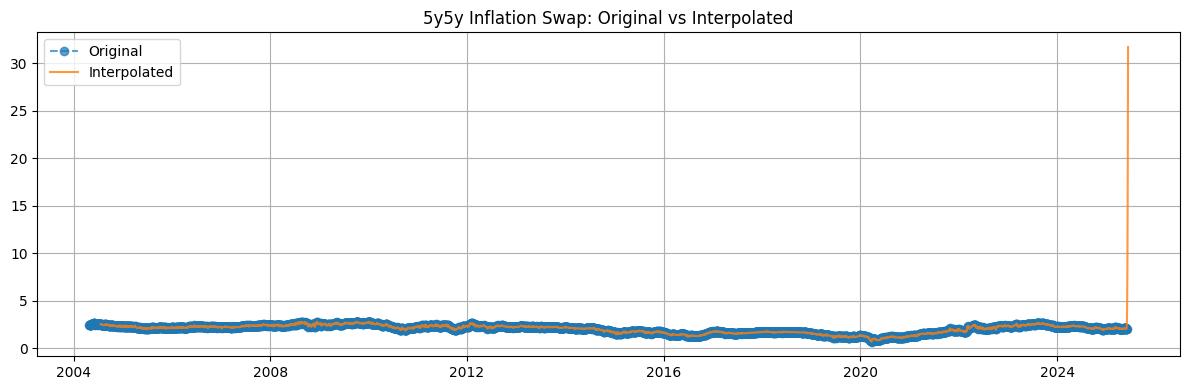

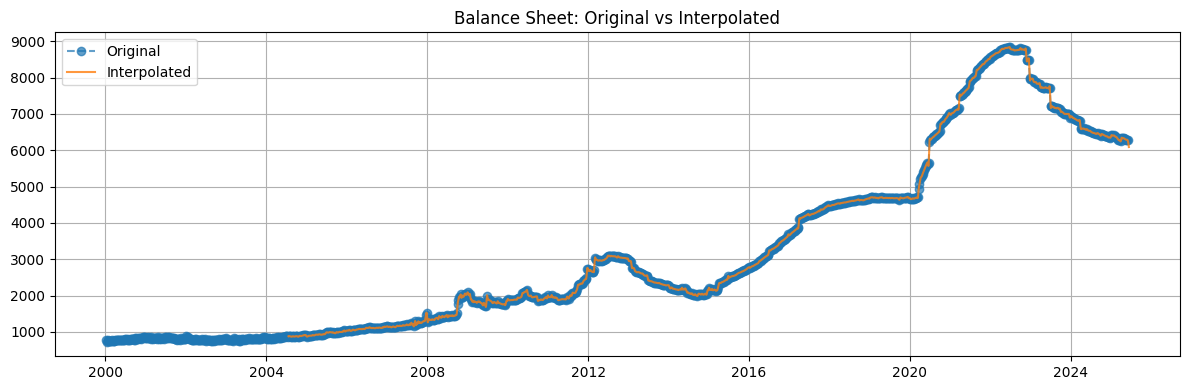

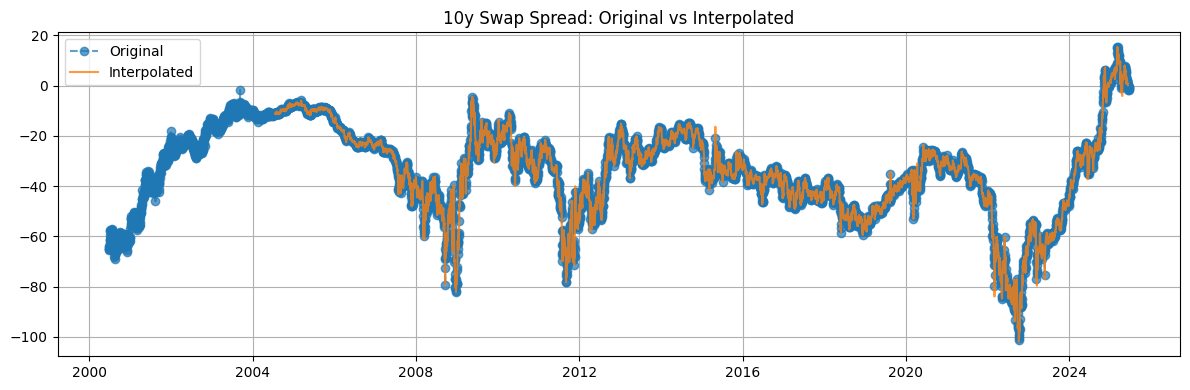

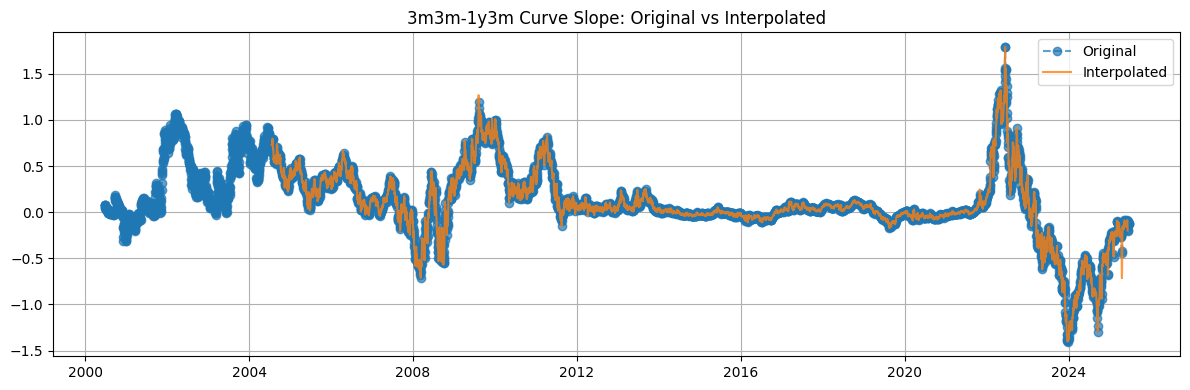

In [6]:
# 1. 5y5y Inflation Swap
plt.figure(figsize=(12, 4))
plt.plot(pd.to_datetime(eur_df['Date_inflation_swap']), eur_df['5y5y inflation swap'], 'o--', label='Original', alpha=0.7)
plt.plot(macro_interp_df['date'], macro_interp_df['5y5y_inflation_swap'], label='Interpolated', alpha=0.8)
plt.title('5y5y Inflation Swap: Original vs Interpolated')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Balance Sheet
plt.figure(figsize=(12, 4))
plt.plot(pd.to_datetime(eur_df['Date_balance_sheet']), eur_df['Balance sheet'], 'o--', label='Original', alpha=0.7)
plt.plot(macro_interp_df['date'], macro_interp_df['balance_sheet'], label='Interpolated', alpha=0.8)
plt.title('Balance Sheet: Original vs Interpolated')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. 10y Swap Spread
plt.figure(figsize=(12, 4))
plt.plot(pd.to_datetime(eur_df['Date_swap_spread']), eur_df['10y Swap Spread'], 'o--', label='Original', alpha=0.7)
plt.plot(macro_interp_df['date'], macro_interp_df['10y_swap_spread'], label='Interpolated', alpha=0.8)
plt.title('10y Swap Spread: Original vs Interpolated')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. 3m3m-1y3m Curve Slope
plt.figure(figsize=(12, 4))
plt.plot(pd.to_datetime(eur_df['Date_3m3m_1y3m']), eur_df['3m3m-1y3m'], 'o--', label='Original', alpha=0.7)
plt.plot(macro_interp_df['date'], macro_interp_df['3m3m_1y3m_curve_slope'], label='Interpolated', alpha=0.8)
plt.title('3m3m-1y3m Curve Slope: Original vs Interpolated')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Prepare rates and volatility data

In [7]:
# Clean swaps data
swaps = pd.read_csv('swap_data.csv')

# Convert years and months to months
def convert_to_months(s):
    if isinstance(s, str):
        s = s.strip().lower()
        if s.endswith('y'):
            return int(s[:-1]) * 12
        elif s.endswith('m'):
            return int(s[:-1])
    return np.nan

swaps['date'] = pd.to_datetime(swaps['date'])
swaps.dropna(subset=['date', 'tenor', 'value'], inplace=True)
swaps['value'] = pd.to_numeric(swaps['value'], errors='coerce')
swaps['start_months'] = swaps['start'].apply(convert_to_months)
swaps['tenor_years'] = swaps['tenor'].str.replace('y', '', regex=False).astype(int)
swaps['tenor_months'] = swaps['tenor'].apply(convert_to_months)

swaps.head()

,date,currency,start,tenor,value,start_months,tenor_years,tenor_months
0,2014-01-02,USD,3m,30y,3.94216,3,30,360
1,2014-01-02,USD,6m,30y,3.99302,6,30,360
2,2014-01-02,USD,3m,3y,1.04138,3,3,36
3,2014-01-02,USD,3m,2y,0.60833,3,2,24
4,2014-01-02,USD,3m,1y,0.36272,3,1,12


In [8]:
yield_vol = pd.read_csv('swaptions_yield_data.csv') # extract ATM percent yield volatilities and corresponding forward swap rates y

# Clean yield volatility data
def convert_to_months(val):
    if val.endswith('Y'):
        return int(val[:-1]) * 12
    elif val.endswith('M'):
        return int(val[:-1])
    else:
        return np.nan
    
yield_vol['date'] = pd.to_datetime(yield_vol['date'])
yield_vol.dropna(subset=['value'], inplace=True)
yield_vol['value'] = pd.to_numeric(yield_vol['value'], errors='coerce')
yield_vol[['currency', 'start_raw', 'tenor_raw']] = yield_vol['label'].str.extract(r'(\w+)_([0-9]+[MY])_([0-9]+Y)')
yield_vol['start_months'] = yield_vol['start_raw'].apply(convert_to_months)
yield_vol['tenor_years'] = yield_vol['tenor_raw'].str.replace('Y', '', regex=False).astype(int)
yield_vol['tenor_months'] = yield_vol['tenor_raw'].apply(convert_to_months)

yield_vol.head()

,date,label,value,currency,start_raw,tenor_raw,start_months,tenor_years,tenor_months
1,2014-01-02,USD_3M_05Y,40.39792,USD,3M,05Y,3,5,60
2,2014-01-03,USD_3M_05Y,39.77956,USD,3M,05Y,3,5,60
3,2014-01-06,USD_3M_05Y,39.96598,USD,3M,05Y,3,5,60
4,2014-01-07,USD_3M_05Y,39.95969,USD,3M,05Y,3,5,60
5,2014-01-08,USD_3M_05Y,40.17965,USD,3M,05Y,3,5,60


In [ ]:
swaptions = pd.read_csv('swaptions_data.csv')

# Clean swaptions data

# Convert years and months to months
def convert_to_months(val):
    if val.endswith('Y'):
        return int(val[:-1]) * 12
    elif val.endswith('M'):
        return int(val[:-1])
    else:
        return np.nan
    
swaptions['date'] = pd.to_datetime(swaptions['date'])
swaptions.dropna(subset=['value'], inplace=True)
swaptions['value'] = pd.to_numeric(swaptions['value'], errors='coerce')
swaptions[['currency', 'start_raw', 'tenor_raw']] = swaptions['label'].str.extract(r'(\w+)_([0-9]+[MY])_([0-9]+Y)')
swaptions['start_months'] = swaptions['start_raw'].apply(convert_to_months)
swaptions['tenor_years'] = swaptions['tenor_raw'].str.replace('Y', '', regex=False).astype(int)
swaptions['tenor_months'] = swaptions['tenor_raw'].apply(convert_to_months)

swaptions.head()    

,date,label,value,currency,start_raw,tenor_raw,start_months,tenor_years,tenor_months
1,2014-01-02,EUR_3M_10Y,61.74100,EUR,3M,10Y,3,10,120
2,2014-01-03,EUR_3M_10Y,60.79753,EUR,3M,10Y,3,10,120
3,2014-01-06,EUR_3M_10Y,61.05012,EUR,3M,10Y,3,10,120
4,2014-01-07,EUR_3M_10Y,60.80262,EUR,3M,10Y,3,10,120
5,2014-01-08,EUR_3M_10Y,60.44799,EUR,3M,10Y,3,10,120


In [10]:
# Merge swaps and yield volatility data

# Merge swaps and swaptions on date, start, tenor, and currency
# Merge swaps and swaptions on date, start, tenor, and currency
swaps = swaps[['date', 'start_months', 'tenor_months', 'currency', 'value']]
swaptions = swaptions[['date', 'start_months', 'tenor_months', 'currency', 'value']]
yield_vol = yield_vol[['date', 'start_months', 'tenor_months', 'currency', 'value']]

# Merge the datasets swaptions and yield_vol
merged_1 = pd.merge(
    swaps,
    swaptions,
    on=['date', 'start_months', 'tenor_months', 'currency'],
    how='inner',
    suffixes=('_rate', '_bp_vol')
)
merged_swaps_vol = pd.merge(
    merged_1,
    yield_vol,
    on=['date', 'start_months', 'tenor_months', 'currency'],
    how='inner'
)
merged_swaps_vol = merged_swaps_vol.sort_values(['date', 'start_months', 'tenor_months'])

merged_swaps_vol.head()

,date,start_months,tenor_months,currency,value_rate,value_bp_vol,value
4,2014-01-02,3,12,USD,0.36272,23.48262,65.40401
107171,2014-01-02,3,12,EUR,0.45872,30.46005,69.00678
193361,2014-01-02,3,12,GBP,0.80009,32.62143,40.83753
3,2014-01-02,3,24,USD,0.60833,39.15793,64.77096
107170,2014-01-02,3,24,EUR,0.61332,37.94298,62.95276


In [11]:
eur_vol_data = merged_swaps_vol[merged_swaps_vol['currency'] == 'EUR']

eur_vol_data = eur_vol_data.rename(columns={'value': 'value_yield_vol'})

eur_vol_data.head()

,date,start_months,tenor_months,currency,value_rate,value_bp_vol,value_yield_vol
107171,2014-01-02,3,12,EUR,0.45872,30.46005,69.00678
107170,2014-01-02,3,24,EUR,0.61332,37.94298,62.95276
107169,2014-01-02,3,36,EUR,0.85224,50.12260,59.37575
107174,2014-01-02,3,60,EUR,1.37835,61.41675,44.86531
107184,2014-01-02,3,84,EUR,1.79245,62.67589,35.07942


# Volatility backbone

In [12]:
# Fit the functional form
def yield_vol_model(y, a, b, c):
    return a * np.exp(-b * y) + c

In [13]:
# EUR
# Fit the model to the data EUR
y = eur_vol_data['value_rate'].values
yvol = eur_vol_data['value_yield_vol'].values

params_eur, _ = curve_fit(yield_vol_model, y, yvol, p0=(100, 2, 20)) # percent annualized yield vol vs rate relationship
a_eur, b_eur, c_eur = params_eur
print(f"Fitted parameters:\na = {a_eur:.4f}, b = {b_eur:.4f}, c = {c_eur:.4f}") 

# Extract parameter uncertainties, the covariance matrix gives standard errors
perr = np.sqrt(np.diag(_))
print("a = %.4f ± %.4f" % (params_eur[0], perr[0]))
print("b = %.4f ± %.4f" % (params_eur[1], perr[1]))
print("c = %.4f ± %.4f" % (params_eur[2], perr[2]))

# Convert fitted yield vols to bp vols: bpvol = yieldvol * y/sqrt(251)
eur_vol_data['fitted_yield_vol'] = yield_vol_model(y, a_eur, b_eur, c_eur) * y / np.sqrt(251) #translate to a daily normal bpvol-vs-rate backbone

# Annualise the volatility values
eur_vol_data['value_bp_vol_daily'] = eur_vol_data['value_bp_vol'] / np.sqrt(251)  # Convert annualised bpvol to daily bpvol

# Residuals EUR
eur_vol_data['residuals'] = eur_vol_data['value_bp_vol_daily'] - eur_vol_data['fitted_yield_vol'] # residual = (actual daily bp vol) – (backbone daily bp vol).

Fitted parameters:
a = 413.3755, b = 3.9778, c = 41.9287
a = 413.3755 ± 1.6494
b = 3.9778 ± 0.0168
c = 41.9287 ± 0.1551


In [14]:
# Reset index
eur_vol_data = eur_vol_data.reset_index(drop=True)
# Show the first 10 rows    
eur_vol_data.head(10)

,date,start_months,tenor_months,currency,value_rate,value_bp_vol,value_yield_vol,fitted_yield_vol,value_bp_vol_daily,residuals
0,2014-01-02,3,12,EUR,0.45872,30.46005,69.00678,3.14416,1.92262,-1.22154
1,2014-01-02,3,24,EUR,0.61332,37.94298,62.95276,3.01840,2.39494,-0.62346
2,2014-01-02,3,36,EUR,0.85224,50.12260,59.37575,3.00497,3.16371,0.15874
3,2014-01-02,3,60,EUR,1.37835,61.41675,44.86531,3.79734,3.87659,0.07925
4,2014-01-02,3,84,EUR,1.79245,62.67589,35.07942,4.78120,3.95607,-0.82513
5,2014-01-02,3,120,EUR,2.25199,61.74100,27.47641,5.96748,3.89706,-2.07042
6,2014-01-02,3,360,EUR,2.78152,53.83748,19.37258,7.36248,3.39819,-3.96429
7,2014-01-02,6,12,EUR,0.51308,35.59502,72.82849,3.09695,2.24674,-0.85021
8,2014-01-02,6,24,EUR,0.70702,45.52554,66.27060,2.97910,2.87355,-0.10555
9,2014-01-02,6,36,EUR,0.96683,56.38178,59.33806,3.09775,3.55879,0.46103


# Merge macro and swaption data

In [15]:
# Merge macro and swaption data on swaption date (many swaptions per date)
eur_vol_data = eur_vol_data.copy()
macro_interp_df = macro_interp_df.copy()

# Merge: for each swaption row, attach the macro factors for that date
eur_vol_macro = eur_vol_data.merge(
    macro_interp_df,
    left_on='date',
    right_on='date',
    how='left'
)
# Show result
eur_vol_macro.head(55)

,date,start_months,tenor_months,currency,value_rate,value_bp_vol,value_yield_vol,fitted_yield_vol,value_bp_vol_daily,residuals,5y5y_inflation_swap,balance_sheet,10y_swap_spread,3m3m_1y3m_curve_slope
0,2014-01-02,3,12,EUR,0.45872,30.46005,69.00678,3.14416,1.92262,-1.22154,2.22130,2282.73207,-17.63500,0.04300
1,2014-01-02,3,24,EUR,0.61332,37.94298,62.95276,3.01840,2.39494,-0.62346,2.22130,2282.73207,-17.63500,0.04300
2,2014-01-02,3,36,EUR,0.85224,50.12260,59.37575,3.00497,3.16371,0.15874,2.22130,2282.73207,-17.63500,0.04300
3,2014-01-02,3,60,EUR,1.37835,61.41675,44.86531,3.79734,3.87659,0.07925,2.22130,2282.73207,-17.63500,0.04300
4,2014-01-02,3,84,EUR,1.79245,62.67589,35.07942,4.78120,3.95607,-0.82513,2.22130,2282.73207,-17.63500,0.04300
5,2014-01-02,3,120,EUR,2.25199,61.74100,27.47641,5.96748,3.89706,-2.07042,2.22130,2282.73207,-17.63500,0.04300
6,2014-01-02,3,360,EUR,2.78152,53.83748,19.37258,7.36248,3.39819,-3.96429,2.22130,2282.73207,-17.63500,0.04300
7,2014-01-02,6,12,EUR,0.51308,35.59502,72.82849,3.09695,2.24674,-0.85021,2.22130,2282.73207,-17.63500,0.04300
8,2014-01-02,6,24,EUR,0.70702,45.52554,66.27060,2.97910,2.87355,-0.10555,2.22130,2282.73207,-17.63500,0.04300
9,2014-01-02,6,36,EUR,0.96683,56.38178,59.33806,3.09775,3.55879,0.46103,2.22130,2282.73207,-17.63500,0.04300


In [16]:
usd_vol_macro.tail(55)

NameError: name 'usd_vol_macro' is not defined

In [ ]:
# Save data in CSV file
eur_vol_macro.to_csv('eur_regression_dataW8.csv', index=False)